# 네이버 플러스 스토어 '탈모' 데이터 분석 노트북 (묶음수량/폰트 처리 포함)

입력 CSV 예상 컬럼:
`스토어, 제목, 원래가격, 현재가격, 할인율, 상품링크, 제조사, 브랜드, 모델명, 원산지, 두피타입, 모발타입, 타입, 제품형태, 용량, 세부제품특징, 향계열, 종류, 성분, 주요제품특징`

- 제목에 `2개/세트/x2/1+1` 등이 있으면 **묶음 수량**으로 인식하여 1개 기준 가격을 계산합니다.
- 그래프 한글 폰트 깨짐을 자동으로 방지합니다.


# 파생 컬럼 산출 로직 (원본 컬럼 기준)

### 1) 가격 관련
- **final_price (최종가격)**  
  사용 컬럼: `현재가격`(우선), 없으면 `가격`, 최후에는 `원래가격` 대체  
  공식: `final_price = 현재가격 or 가격 or 원래가격`

- **unit_count (묶음 수량)**  
  사용 컬럼: `제목`  
  규칙:  
  - 프로모션형: `1+1`, `2+1` → 두 숫자의 합 (예: 1+1→2, 2+1→3)  
  - 곱셈형: `x2`, `*3` → 뒤 숫자 그대로 (예: x2→2)  
  - 단위형: `2개`, `2세트`, `2ea`, `2개입`, `2팩`, `2입` → 숫자를 수량으로 인식  
  - 주의: `100ml`, `200g` 같은 용량 단위는 수량으로 보지 않음  
  기본값: 매칭 없으면 1

- **final_price_per_unit (1개 기준 가격)**  
  사용 컬럼: `final_price`, `unit_count`  
  공식: `final_price_per_unit = final_price ÷ unit_count`

### 2) 용량/단위가격
- **volume_ml (총 용량, ml)**  
  사용 컬럼: `용량` (비면 `제목`+설명에서 보조 추출)  
  규칙:  
  - `100ml`, `0.5L`, `200g`, `500mg` → ml로 환산 (L→×1000, mg→÷1000, g≈ml 근사)  
  - `2 x 100ml`, `100ml*2` → 곱하여 총용량(예: 2×100ml→200ml)

- **price_per_ml (ml당 가격)**  
  사용 컬럼: `final_price`, `volume_ml`  
  공식: `price_per_ml = final_price ÷ volume_ml` (총 용량 기준)

### 3) 분류/타입
- **category (카테고리 추정)**  
  사용 컬럼: `종류`, `타입`, `제품형태` (+ 보조로 `제목`/설명)  
  키워드 매칭 예: 샴푸 / 토닉 / 앰플·세럼 / 오일·트리트먼트 / 영양제(비의약품) / 기타

- **type_raw (원본 타입)**  
  사용 컬럼: `타입` (없으면 category로 대체)

- **type_mapped (샴푸/샴푸바)**  
  사용 컬럼: `type_raw`  
  규칙: 문자열에 `샴푸` 포함 → `샴푸`, 아니면 `샴푸바`

### 4) 설명/키워드 플래그
- **desc**: `성분` + `주요제품특징` + `세부제품특징` 결합  
- **is_peptide / is_low_stimulus / is_clinical**: `제목`+`desc` 텍스트 키워드 매칭 → True/False  
- **ING_* 시리즈**: 성분 키워드 매칭 → 1/0

### 5) 보조
- **list_price**: `원래가격` (비면 `final_price`로 대체)  
- **discount_rate**: `할인율`(숫자화)  
- **date_parsed**: `등록일/갱신일`(있을 때) → datetime 변환


In [35]:
from pathlib import Path
import json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime as dt

INPUT_CSV = "naver_hairloss_products_with_specs_20250929_PM114126.csv"   # 여기에 파일명 입력
OUTDIR = Path(f"out_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}")
CONFIG_JSON = None  # 예: 'config_keywords.json' (없으면 기본값 사용)

In [36]:
def setup_korean_font():
    from matplotlib import font_manager, rcParams
    candidates = ["AppleGothic","Malgun Gothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR","NanumBarunGothic"]
    available = set(f.name for f in font_manager.fontManager.ttflist)
    chosen = None
    for c in candidates:
        if c in available:
            chosen = c; break
    if chosen:
        rcParams["font.family"] = chosen
    rcParams["axes.unicode_minus"] = False
    return chosen

setup_korean_font()

'Malgun Gothic'

In [37]:
def map_type_shampoo_vs_bar(s) -> str:
    import pandas as pd
    if pd.isna(s): return "샴푸바"
    t = str(s).lower()
    return "샴푸" if "샴푸" in t else "샴푸바"


In [38]:
DEFAULT_CONFIG = {
    "peptide_keywords": ["펩타이드", "peptide", "GHK", "GHK-Cu", "구리펩타이드", "copper peptide"],
    "low_stimulus_keywords": ["저자극", "무실리콘", "무향", "민감성", "무알콜", "약산성"],
    "clinical_keywords": ["임상", "피부과테스트", "더마테스트", "인체적용시험", "유효성"],
    "ingredient_keywords": [
        "미녹시딜","피나스테리드","카페인","비오틴","나이아신아마이드","덱스판테놀","징크피리치온",
        "세라마이드","징크","로즈마리","녹차","쑥","판테놀"
    ],
    "category_guess": {
        "샴푸": ["샴푸"],
        "토닉": ["토닉","스캘프 토닉","헤어토닉"],
        "앰플/세럼": ["앰플","세럼","에센스","부스터"],
        "오일/트리트먼트": ["오일","트리트먼트","팩","마스크"],
        "영양제(비의약품)": ["영양제","보충제","캡슐","정","환"]
    },
    "recent_days_for_new": 90
}

POSSIBLE_COLS = {
    "name": ["제목","상품명","제품명","title","name"],
    "store": ["스토어","스토어명","판매처","상호","store","seller"],
    "brand": ["브랜드","brand"],
    "category": ["카테고리","분류","종류","타입","제품형태","category"],
    "price": ["현재가격","할인가격","할인가","판매가격","가격","판매가","원래가격","정가","price"],
    "list_price": ["원래가격","정가"],
    "discount_price": ["현재가격","할인가격","할인가","판매가격","discount_price"],
    "discount_rate": ["할인율","할인율(%)","discount_rate"],
    "volume": ["용량","용량표기","중량","용량(g/ml)","용량(ml)","용량(g)","volume"],
    "date": ["등록일","갱신일","등록/갱신","date","updated_at","created_at"],
    "url": ["상품링크","링크","url"],
    "desc": ["성분","주요제품특징","세부제품특징","상세요약","상세","설명","요약","description","desc","썸네일ALT","썸네일텍스트"],
    "type_raw": ["타입"],
    "reviews": ["리뷰수","리뷰","구매평","reviews","review_count"],
    "rating": ["평점","rating","별점"]
}

In [39]:
def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True); return p
def krw_fmt(x, pos=None):
    try: return f"{int(x):,}원"
    except: return str(x)
def load_config(path: str | None):
    if path and Path(path).exists():
        cfg = json.loads(Path(path).read_text(encoding='utf-8'))
        merged = DEFAULT_CONFIG.copy(); merged.update(cfg); return merged
    return DEFAULT_CONFIG
def guess_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map: return lower_map[c.lower()]
    return None
def build_schema(df):
    return {k: guess_col(df, v) for k,v in POSSIBLE_COLS.items()}

In [40]:
def to_numeric(s):
    if s is None: return None
    return (s.astype(str).str.replace(r"[^\d\.\-]","", regex=True)
            .replace({"": np.nan, "-": np.nan}).astype(float))
def parse_volume_to_ml(x: str):
    if pd.isna(x): return np.nan
    s = str(x).lower().replace(" ", "")
    m = re.findall(r"(\d+(?:\.\d+)?)\s*(?:x|\*)\s*(\d+(?:\.\d+)?)(ml|l|g|mg)", s)
    if m:
        qty = float(m[0][0]); val = float(m[0][1]); unit = m[0][2]
        per = val*(1000 if unit=="l" else 1) if unit in ["ml","l"] else val
        if unit=="mg": per = val/1000.0
        return qty * per
    m2 = re.findall(r"(\d+(?:\.\d+)?)(ml|l|g|mg)", s)
    if m2:
        val = float(m2[0][0]); unit = m2[0][1]
        if unit=="ml": return val
        if unit=="l": return val*1000.0
        if unit=="mg": return val/1000.0
        if unit=="g": return val
    return np.nan
def parse_pack_qty(name_text: str) -> int:
    if not isinstance(name_text, str):
        return 1
    s = name_text.lower()
    m = re.search(r'(\d+)\s*\+\s*(\d+)', s)
    if m:
        try: return max(1, int(m.group(1)) + int(m.group(2)))
        except: pass
    m = re.search(r'(?:x|\*)\s*(\d+)\b', s)
    if m:
        try: return max(1, int(m.group(1)))
        except: pass
    cand = 1
    for g in re.findall(r'(\d+)\s*(개|세트|set|입|ea|팩)\b', s):
        cand = max(cand, int(g[0]))
    for g in re.findall(r'(\d+)(개입|세트|입|ea|팩)', s):
        cand = max(cand, int(g[0]))
    return max(1, cand)
def clean_df(df, schema):
    for k in ["name","store","price"]:
        if not schema.get(k):
            raise ValueError(f"필수 컬럼 누락: {k}")
    out = pd.DataFrame()
    for k, col in schema.items():
        out[k] = df[col] if (col and col in df.columns) else np.nan
    out["price"] = to_numeric(out.get("price"))
    if schema.get("discount_price"): out["discount_price"] = to_numeric(out.get("discount_price"))
    if schema.get("list_price"): out["list_price"] = to_numeric(out.get("list_price"))
    if schema.get("discount_rate"): out["discount_rate"] = to_numeric(out.get("discount_rate"))
    if schema.get("rating"): out["rating"] = to_numeric(out.get("rating"))
    if schema.get("reviews"): out["reviews"] = to_numeric(out.get("reviews"))
    desc_cols = [schema.get("desc")] if schema.get("desc") else []
    for extra in ["성분","주요제품특징","세부제품특징"]:
        if extra in df.columns and extra not in desc_cols: desc_cols.append(extra)
    out["desc"] = df[desc_cols].astype(str).apply(lambda r: " ".join([x for x in r if x and x!="nan"]), axis=1) if desc_cols else ""
    vol_src = out.get("volume")
    if isinstance(vol_src, pd.Series) and vol_src.isna().all():
        vol_src = out["name"].fillna("").astype(str) + " " + out["desc"].fillna("").astype(str)
    out["volume_ml"] = vol_src.apply(parse_volume_to_ml) if isinstance(vol_src, pd.Series) else np.nan
    out["final_price"] = (out.get("discount_price").where(~pd.isna(out.get("discount_price")), out["price"]) if "discount_price" in out.columns else out["price"])
    if "list_price" in out.columns:
        out["list_price"] = out["list_price"].where(~pd.isna(out["list_price"]), out["final_price"]) 
    out["unit_count"] = out["name"].astype(str).apply(parse_pack_qty)
    out["final_price_per_unit"] = out["final_price"] / out["unit_count"]
    out["price_per_ml"] = out["final_price"]/out["volume_ml"]
    # 타입 원본/맵핑 추가
    if schema.get("type_raw") and schema["type_raw"] in df.columns:
        out["type_raw"] = df[schema["type_raw"]]
    else:
        out["type_raw"] = out.get("category")
    out["type_mapped"] = out["type_raw"].apply(map_type_shampoo_vs_bar)
    if schema.get("date"): out["date_parsed"] = pd.to_datetime(out["date"], errors="coerce")
    return out

In [41]:
def make_flags(df, cfg):
    text = (df["name"].fillna("").astype(str) + " " + df["desc"].fillna("").astype(str)).str.lower()
    def flag_any(keys):
        if not keys: return pd.Series([False]*len(df))
        pat = "|".join([re.escape(k.lower()) for k in keys])
        return text.str.contains(pat, regex=True)
    df["is_peptide"] = flag_any(cfg["peptide_keywords"])
    df["is_low_stimulus"] = flag_any(cfg["low_stimulus_keywords"])
    df["is_clinical"] = flag_any(cfg["clinical_keywords"])
    for k in cfg["ingredient_keywords"]:
        df[f"ING_{k}"] = text.str_contains = text.str.contains(re.escape(k.lower())).astype(int)
    if "category" not in df.columns or df["category"].isna().all():
        guess = np.array(["기타"]*len(df))
        for cname, keys in cfg["category_guess"].items():
            pat = "|".join([re.escape(k.lower()) for k in keys])
            guess = np.where(text.str.contains(pat), cname, guess)
        df["category"] = guess
    return df

In [42]:
def calc_kpis(df, cfg):
    price = df["final_price_per_unit"].dropna()
    k = {
        "n_products": len(df),
        "n_stores": df["store"].nunique(dropna=True),
        "n_brands": df["brand"].nunique(dropna=True) if "brand" in df.columns else None,
        "price_med": float(price.median()) if not price.empty else None,
        "price_q1": float(price.quantile(0.25)) if not price.empty else None,
        "price_q3": float(price.quantile(0.75)) if not price.empty else None,
        "recent_ratio": None,
        "hot_median": None,
        "spearman_price_reviews": None,
        "hhi_reviews": None
    }
    if "date_parsed" in df.columns and df["date_parsed"].notna().any():
        cutoff = pd.Timestamp(dt.datetime.now() - dt.timedelta(days=cfg["recent_days_for_new"]))
        k["recent_ratio"] = float((df["date_parsed"] >= cutoff).mean())
    return k

In [43]:
def save_price_hist(df, outdir, show=False):
    s = df["final_price_per_unit"].dropna()
    if len(s)==0: return None
    plt.figure(); plt.hist(s, bins=30)
    plt.xlabel("1개 기준 가격(원)"); plt.ylabel("상품 수")
    plt.gca().xaxis.set_major_formatter(FuncFormatter(krw_fmt))
    path = outdir/"chart_price_per_unit_hist.png"
    plt.tight_layout(); plt.savefig(path); plt.close(); return path


def save_category_bar(df, outdir, show=False):
    import matplotlib.pyplot as plt
    grp = df.groupby("category")["final_price_per_unit"].count().sort_values(ascending=False)
    if len(grp)==0: return None
    fig = plt.figure()
    bars = plt.bar(grp.index.astype(str), grp.values)
    plt.title("카테고리별 상품 수")
    plt.xticks(rotation=45, ha="right"); plt.ylabel("상품 수")
    for bar, val in zip(bars, grp.values):
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height(), f"{int(val)}", ha="center", va="bottom", fontsize=9)
    path = outdir / "chart_category_count_bar.png"
    plt.tight_layout(); plt.savefig(path)
    if show: plt.show()
    plt.close(); return path




def save_ingredient_bar(df, cfg, outdir, show=False):
    import matplotlib.pyplot as plt
    cols = [c for c in df.columns if c.startswith("ING_")]
    if not cols: return None
    sums = df[cols].sum().sort_values(ascending=False).head(15)
    fig = plt.figure()
    y_labels = sums.index.str.replace("ING_","",regex=False)
    bars = plt.barh(y_labels, sums.values)
    plt.title("성분 키워드 TOP15")
    plt.xlabel("키워드 등장 상품 수")
    for bar, val in zip(bars, sums.values):
        plt.text(val, bar.get_y()+bar.get_height()/2, f"{int(val)}", va="center", ha="left", fontsize=9)
    path = outdir / "chart_ingredients_top15.png"
    plt.tight_layout(); plt.savefig(path)
    if show: plt.show()
    plt.close(); return path




def save_price_per_ml_box(df, outdir, show=False):
    import numpy as np
    import matplotlib.pyplot as plt
    d = df.dropna(subset=["price_per_ml","category"])
    if len(d)==0: return None
    cats = d["category"].astype(str).unique().tolist()
    data = [d.loc[d["category"].astype(str)==c, "price_per_ml"].values for c in cats]
    fig = plt.figure()
    bp = plt.boxplot(data, labels=cats, showfliers=False)
    plt.title("카테고리별 ml당 가격 (Boxplot)")
    plt.ylabel("ml당 가격(원)")
    ax = plt.gca()
    medians = [float(np.median(vals)) if len(vals)>0 else float("nan") for vals in data]
    for i, med in enumerate(medians, start=1):
        if not np.isnan(med):
            plt.text(i + 0.2, med, f"{int(med):,}", ha="left", va="center", fontsize=9)  # offset for visibility
    ax.margins(y=0.1)
    path = outdir / "chart_price_per_ml_box.png"
    plt.tight_layout(); plt.savefig(path)
    if show: plt.show()
    plt.close(); return path




def save_whitespace_matrix(df, outdir, show=False):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    pivot = pd.pivot_table(df, index="is_peptide", columns="is_low_stimulus", values="final_price_per_unit", aggfunc="mean")
    if pivot.size==0: return None
    fig = plt.figure()
    ax = plt.gca()
    arr = pivot.values
    im = plt.imshow(arr, aspect="auto")
    plt.title("화이트스페이스: 펩타이드 × 저자극 (평균 1개 가격)")
    ax.set_xlabel("저자극 여부 (is_low_stimulus)")
    ax.set_ylabel("펩타이드 여부 (is_peptide)")
    xticks = list(range(pivot.shape[1])); yticks = list(range(pivot.shape[0]))
    ax.set_xticks(xticks); ax.set_yticks(yticks)
    ax.set_xticklabels([str(c) for c in pivot.columns])
    ax.set_yticklabels([str(r) for r in pivot.index])
    ax.set_xticks(np.arange(-.5, pivot.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, pivot.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=1)
    cb = plt.colorbar(im); cb.set_label("평균 1개 가격(원)")
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = arr[i, j]; txt = "-" if pd.isna(val) else f"{int(val):,}"
            plt.text(j, i, txt, ha="center", va="center", fontsize=9)
    path = outdir / "chart_whitespace_matrix.png"
    plt.tight_layout(); plt.savefig(path)
    if show: plt.show()
    plt.close(); return path


    plt.tight_layout(); plt.savefig(path); plt.close(); return path

In [44]:
def write_markdown_report(outdir, kpis, chart_paths, df):
    def today_str(): return dt.datetime.now().strftime("%Y.%m.%d")
    lines = []
    lines.append(f"# 네이버 플러스 스토어 '탈모' 시장 스냅샷 ({today_str()})\n")
    lines.append("## 핵심 KPI")
    lines.append(f"- 총 상품 수: **{kpis.get('n_products',0):,}**개")
    lines.append(f"- 스토어 수: **{kpis.get('n_stores',0):,}**곳")
    if kpis.get("n_brands") is not None:
        lines.append(f"- 브랜드 수: **{kpis['n_brands']:,}**개")
    if kpis.get("recent_ratio") is not None:
        lines.append(f"- 최근 90일 신규/갱신 비중: **{kpis['recent_ratio']*100:.1f}%**")
    if kpis.get("price_med") is not None:
        lines.append(f"- **1개 기준 가격** 중앙값(IQR): **{int(kpis['price_med']):,}원** (Q1: {int(kpis['price_q1']):,}원, Q3: {int(kpis['price_q3']):,}원)")
    lines.append("- (참고) 본 시트에는 리뷰/평점 컬럼이 없어 수요/집중도 지표는 생략했습니다.")
    lines.append("\n## 인사이트(사업계획서 문장 템플릿)")
    pr_med = kpis.get("price_med")
    if pr_med is not None:
        lines.append(f"- 제목 내 묶음 수량 보정 후 1개 기준 가격 중앙값은 **{int(pr_med):,}원**.")
    lines.append("- 카테고리(종류/타입/제품형태 기반 추정)별 ml당 가격 비교 → 프리미엄/가성비 포지셔닝.")
    lines.append("- 성분/클레임 키워드 출현율로 트렌드 파악.")
    lines.append("- (화이트스페이스) 펩타이드×저자극 조합의 평균 1개 가격 차이 확인.")
    lines.append("\n## 차트")
    for p in chart_paths:
        if p is None: continue
        lines.append(f"![{p.name}]({p.name})")
    # 추가: 그래프 설명 섹션 (데이터 컬럼 & 계산 방식)
    lines.append("\n## 그래프 설명 (데이터 컬럼 & 계산 방식)")
    if any(p for p in chart_paths if p and p.name=="chart_price_per_unit_hist.png"):
        lines.append("- **1개 기준 가격 분포 (chart_price_per_unit_hist.png)**: `final_price_per_unit`(= `final_price` ÷ `unit_count`) 히스토그램. 막대 위 숫자는 각 구간의 상품 개수.")
    if any(p for p in chart_paths if p and p.name=="chart_category_count_bar.png"):
        lines.append("- **카테고리별 상품 수 (chart_category_count_bar.png)**: `category`별 상품 수. 막대 위 숫자는 개수.")
    if any(p for p in chart_paths if p and p.name=="chart_ingredients_top15.png"):
        lines.append("- **성분 키워드 TOP15 (chart_ingredients_top15.png)**: `ING_*` 합계(텍스트에서 키워드 매칭). 우측 숫자는 키워드 포함 상품 수.")
    if any(p for p in chart_paths if p and p.name=="chart_price_per_ml_box.png"):
        lines.append("- **카테고리별 ml당 가격 (chart_price_per_ml_box.png)**: `price_per_ml` 박스플롯, 박스 위 숫자는 중앙값.")
    if any(p for p in chart_paths if p and p.name=="chart_whitespace_matrix.png"):
        lines.append("- **화이트스페이스(펩타이드×저자극) (chart_whitespace_matrix.png)**: `final_price_per_unit` 평균 히트맵. 셀 숫자는 평균 1개 가격.")

    out_md = OUTDIR/"report.md"; out_md.write_text("\n".join(lines), encoding='utf-8'); out_md

In [45]:
CFG = load_config(CONFIG_JSON)
OUTDIR = ensure_dir(OUTDIR)
df_raw = pd.read_csv(INPUT_CSV, encoding='utf-8')
schema = build_schema(df_raw)
df = clean_df(df_raw, schema)
df = make_flags(df, CFG)
df.head(3)

,name,store,brand,category,price,list_price,discount_price,discount_rate,volume,date,...,ING_비오틴,ING_나이아신아마이드,ING_덱스판테놀,ING_징크피리치온,ING_세라마이드,ING_징크,ING_로즈마리,ING_녹차,ING_쑥,ING_판테놀
0,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 1개",바이브랩,바이브랩,NaN,30900.0,32000.0,30900.0,0.03,500ml,NaN,...,0,0,0,0,0,0,0,0,0,0
1,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 2개",바이브랩,바이브랩,NaN,60900.0,62000.0,60900.0,0.01,500ml,NaN,...,0,0,0,0,0,0,0,0,0,0
2,두피진정 탈모샴푸300ml+100ml 앰플증정,Solep,솔랩,NaN,25400.0,35000.0,25400.0,0.27,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# === 타입 유니크 값 확인 & 저장 ===
type_counts = df['type_raw'].fillna('(NaN)').astype(str).value_counts(dropna=False).reset_index()
type_counts.columns = ['type_raw_value','count']
type_csv_path = OUTDIR / 'type_unique_counts.csv'
type_counts.to_csv(type_csv_path, index=False, encoding='utf-8-sig')
type_counts.head(30)  # 상위 30개 미리보기

,type_raw_value,count
0,(NaN),6066
1,탈모샴푸,1208
2,"탈모샴푸, 두피샴푸",420
3,"탈모샴푸, 비듬샴푸, 두피샴푸",216
4,"일반샴푸, 탈모샴푸",181
5,일반샴푸,158
6,"탈모샴푸, 천연샴푸, 두피샴푸",144
7,"일반샴푸, 탈모샴푸, 두피샴푸",134
8,"탈모샴푸, 두피샴푸, 비듬샴푸",101
9,"탈모샴푸, 두피샴푸, 일반샴푸",68


In [47]:
kpis = calc_kpis(df, CFG)
kpis

{'n_products': 10095,
 'n_stores': 3452,
 'n_brands': 1942,
 'price_med': 27000.0,
 'price_q1': 16980.0,
 'price_q3': 43732.5,
 'recent_ratio': None,
 'hot_median': None,
 'spearman_price_reviews': None,
 'hhi_reviews': None}

In [48]:
# === 묶음 수량 파싱 결과 미리보기 ===
df[['name','unit_count','final_price','final_price_per_unit']].head(15)

,name,unit_count,final_price,final_price_per_unit
0,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 1개",1,30900.0,30900.000000
1,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 2개",2,60900.0,30450.000000
2,두피진정 탈모샴푸300ml+100ml 앰플증정,1,25400.0,25400.000000
3,라보에이치 여름 쿨샴푸 지성 탈모 대용량 두피스케일링 400ml&400ml리필&180ml,1,29800.0,29800.000000
4,려 루트젠 두피 에센스 대용량 145ml 두피 영양제 여성 남성 탈모 앰플,1,23900.0,23900.000000
5,라보에이치 탈모샴푸 약산성 대용량 두피 비건 400ml+400ml리필+180ml,1,29800.0,29800.000000
6,려 루트젠 탈모샴푸 대용량 약산성 여성 비건 볼륨 두피 515ml+242ml+100ml,1,26800.0,26800.000000
7,"나인밀라 카밍비어 (맥주효모) 탈모샴푸 (+리필 추가선택) 자몽향, 500ml, 2개",2,29900.0,14950.000000
8,"네이처리퍼블릭 블랙빈 안티 헤어로스 샴푸(신형) 520ml, 2개",2,32900.0,16450.000000
9,"닥터포헤어 바이오3 폴리젠 탈모완화 샴푸 허브향, 500ml, 3개",3,41900.0,13966.666667


In [49]:
# === 타입(샴푸/샴푸바) 분포 차트 ===
grp = df['type_mapped'].value_counts()
plt.figure(); plt.bar(grp.index.astype(str), grp.values)
plt.ylabel('상품 수'); plt.xlabel('타입 분류(샴푸/샴푸바)')
plt.tight_layout();
chart_type_path = OUTDIR / 'chart_type_mapped_bar.png'
plt.savefig(chart_type_path); plt.close(); chart_type_path

WindowsPath('out_20251023_231316/chart_type_mapped_bar.png')

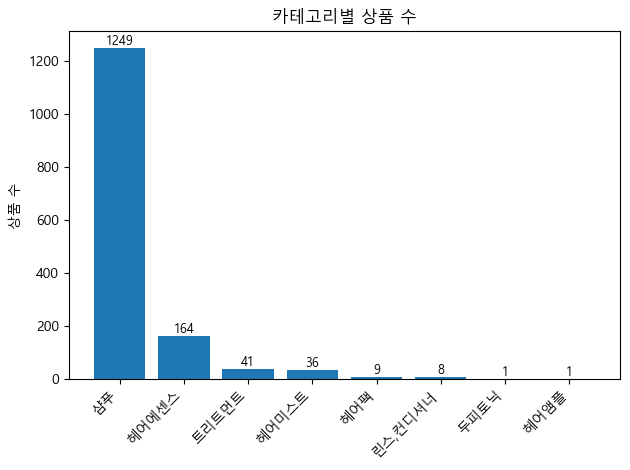

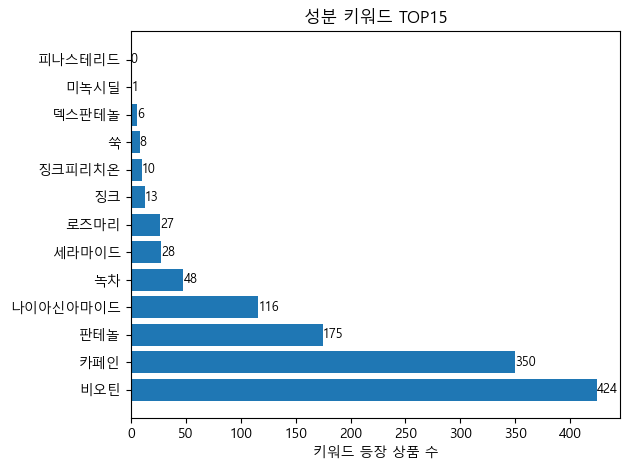

C:\Users\kbjoo\AppData\Local\Temp\ipykernel_46064\2351315977.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=cats, showfliers=False)


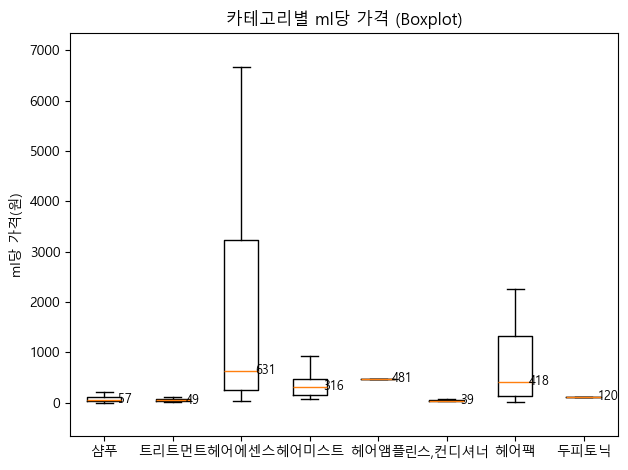

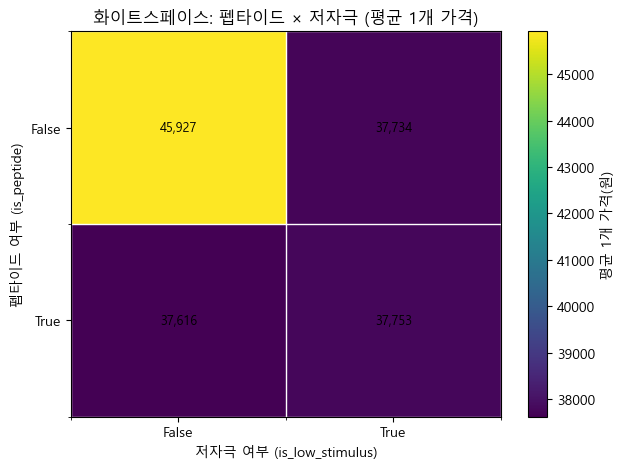

[WindowsPath('out_20251023_231316/chart_price_per_unit_hist.png'),
 WindowsPath('out_20251023_231316/chart_category_count_bar.png'),
 WindowsPath('out_20251023_231316/chart_ingredients_top15.png'),
 WindowsPath('out_20251023_231316/chart_price_per_ml_box.png'),
 WindowsPath('out_20251023_231316/chart_whitespace_matrix.png')]

In [50]:
charts = []
charts.append(save_price_hist(df, OUTDIR, show=True))
charts.append(save_category_bar(df, OUTDIR, show=True))
charts.append(save_ingredient_bar(df, CFG, OUTDIR, show=True))
charts.append(save_price_per_ml_box(df, OUTDIR, show=True))
charts.append(save_whitespace_matrix(df, OUTDIR, show=True))
charts

In [51]:
report_md = write_markdown_report(OUTDIR, kpis, charts, df)
report_md